In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [32]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *
from scipy import signal
from scipy import stats
from scipy.signal import convolve as sig_convolve
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datajoint as dj
dj.config['database.host'] = 'at-database.ad.bcm.edu'
dj.config['database.user'] = 'raj'
dj.config['database.password'] = 'language-wonderful-joy-system'
dj.conn()

DataJoint connection (connected) raj@at-database.ad.bcm.edu:3306

In [3]:
from stimulus import stimulus
import datajoint as dj
tune=dj.create_virtual_module('tune','pipeline_tune')
GNN=dj.create_virtual_module('GNN', 'pipeline_GNN')
meso=dj.create_virtual_module('meso','pipeline_meso')

In [4]:
# define custom functions
def pick_indices(x,l,u):
    id_s = np.nonzero(x >= l)[0]
    id_e = np.nonzero(x <= u)[0]
    return np.intersect1d(id_s,id_e)

def vonMisesFn(x,amp,scale,theta0):
    return amp*np.exp(scale*np.cos(2*(x-theta0)))

def expandN_dims(x,N):
    for i in range(N):
        x = np.expand_dims(x,axis=1)
    return x

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [5]:
# good ones
# key = dict(animal_id=17797, session=6, scan_idx=8)
key = dict(animal_id=18142, session=7, scan_idx=2)

# perhaps bad ones
# key = dict(animal_id=17797, session=9, scan_idx=7)
# key = dict(animal_id=18252, session=15, scan_idx=3)

In [6]:
# get the ms_delay
delayinfo = (meso.ScanSet.UnitInfo() & key).fetch(dj.key, 'ms_delay',order_by='unit_id')
ms_delay = delayinfo[1]/1000

# get the frame_times
trial_keys, depths = (meso.ScanInfo.Field() & key).fetch(dj.key,'z')
Ndepths = len(np.unique(depths))
print('Ndepths =', Ndepths)
trial_keys, frame_times = (stimulus.Sync() & key).fetch(dj.key, 'frame_times')
frame_times = frame_times[0].squeeze()[::Ndepths]
print('Size of frame_times =',np.shape(frame_times))
print('dt_frame =', np.mean(np.diff(frame_times)))

# get the flip times 
trial_keys, fliptimes = (stimulus.Trial() & key).fetch(dj.key, 'flip_times')
fliptimes = np.stack(fliptimes,axis=0).squeeze(axis=1)
print('Size of fliptimes =',fliptimes.shape)

Ndepths = 2
Size of frame_times = (55000,)
dt_frame = 0.08040124735517236
Size of fliptimes = (120, 1800)


In [7]:
# get the traces for all the neurons
trace_keys, traces=(meso.Activity.Trace() & key).fetch(dj.key, 'trace', order_by='unit_id')
traces = np.stack(traces,axis=0)
print('Shape of traces =',traces.shape)

NNeu = traces.shape[0]
print('No. of neurons in the scan =', NNeu)

Shape of traces = (3926, 55000)
No. of neurons in the scan = 3926


In [8]:
# filter the traces
b = np.hamming(5)
b = b/sum(b)
traces = signal.filtfilt(b,1,traces,axis=1)

# for each neuron, normalize the trace by the std of the non-zero bins
traces = np.round(traces*100)/100.0
for i in range(NNeu):
    idx = np.nonzero(traces[i,:] != 0)
    s = traces[i,idx].std()
    traces[i,:] = traces[i,:]/s
    

# account for ms_delay in the frametimes by nearest neighbor interpolation
# i.e., syncing activity of all the neurons with frame_times
dt = np.mean(np.diff(frame_times))

for k in range(NNeu):
    if ms_delay[k] >= dt/2:
        traces[k,1:] = traces[k,0:-1]


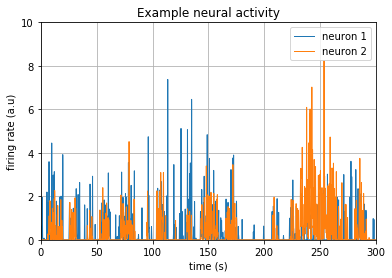

In [9]:
# plotting the activity of 2 example neurons 
i = 999
t = 20000
fig, ax = plt.subplots()
ax.plot(dt*np.arange(3750),traces[i,t:t+3750],linewidth = 1)
ax.plot(dt*np.arange(3750),traces[i+17,t:t+3750],linewidth = 1)
ax.legend(['neuron 1','neuron 2'])
ax.set(xlabel='time (s)', ylabel='firing rate (a.u)', title='Example neural activity')
ax.axis([0,300,0,10])
ax.grid('on')
fig.savefig('Figures/example_trace.png',dpi=300)
fig.savefig('Figures/example_trace.pdf')
plt.show()

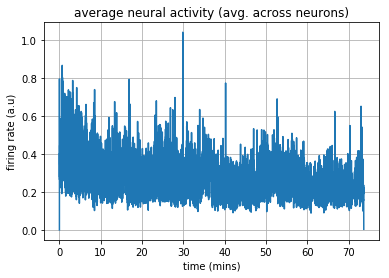

In [10]:
# look at average neural activty vs. time. This is to see if there are any trends in the responses 
# average is taken across all the neurons
fig, ax = plt.subplots()
ax.plot(np.arange(np.shape(traces)[1])*dt/60,np.mean(traces,axis=0))
ax.set(xlabel='time (mins)', ylabel = 'firing rate (a.u)', 
       title = 'average neural activity (avg. across neurons)')
ax.grid('on')
fig.savefig('Figures/Average_activity.png',dpi=300)
fig.savefig('Figures/Average_activity.pdf',dpi=300)
plt.show()

In [11]:
# load the labels from mat files for the two repetitions of the stimulus
# These labels identify the condition and stimulus parameters
Data = loadmat('idx1.mat')
Cidx1 = Data['idx1'].squeeze()-1 # condition label
Data = loadmat('idx2.mat')
Cidx2 = Data['idx2'].squeeze()-1 # condition label

aidx1 = np.argsort(Cidx1) # use these to match the two sets
aidx2 = np.argsort(Cidx2)

# print('The order in which the stimulus conditions were presented:\n')
# print(Cidx1)
# print(Cidx2)
# print('\n 0 to 39 correspond to Varma, 40 to 50 are CM Trippy')

In [12]:
# Arrange the responses according to condition label to 
# compute the cross-correlation of the filtered responses

# first, z-score the responses
traces_z = stats.zscore(traces,axis=1)

Nc = fliptimes.shape[0] # no. of conditions
TVec = np.zeros(Nc)

# Here I am finding the number of samples of neural activity for each condition 
for ii in range(Nc):
    TVec[ii] = len(pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1]))
    
# I am choosing the min of TVec as the number of samples for all conditions. 
# This is just so I can arrange my data in a matrix to enable easy computation of correlations
T = int(np.min(TVec))

# Arrange the z-scored responses according to the condition label
traces_s = np.zeros([Nc,NNeu,T])
for ii in range(Nc):
    idx = pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1])[0:T]
    traces_s[ii,:,:] = traces_z[:,idx]


In [13]:
# computing the cross correlations

Ntau = 20 
Corr = np.zeros([int(Nc/2), NNeu, 2*Ntau+1]) #Nc/2 because there are 2 repetitions of each cond
F = 4 #no. of time samples for each lag

for ii in range(int(Nc/2)):
    #print(ii)
    # pick the 2 sets of neural activity corresponding to the two conditions
    # here we are looking at the sequence of conditions from 0,1,2... 
    r1 = traces_s[aidx1[ii],:,:]
    r2 = traces_s[int(Nc/2)+aidx2[ii],:,:]
    
    r1 = stats.zscore(r1)
    r2 = stats.zscore(r2)
    

    for tau in range(-Ntau,Ntau+1):
        if tau < 0:
            Corr[ii,:,tau+Ntau] = np.mean(r1[:,-F*tau:]*r2[:,0:T+F*tau],axis=1)
        elif tau >= 0:
            Corr[ii,:,tau+Ntau] = np.mean(r1[:,0:T-F*tau]*r2[:,F*tau:],axis=1)

Corr = np.mean(Corr,axis=0)

# if required, save the cross correlation 
# f = str(key['animal_id']) + '_' + str(key['session']) + '_' + str(key['scan_idx']) + '.mat'
# print(f)

# savemat(f, {'CorrMat':Corr})

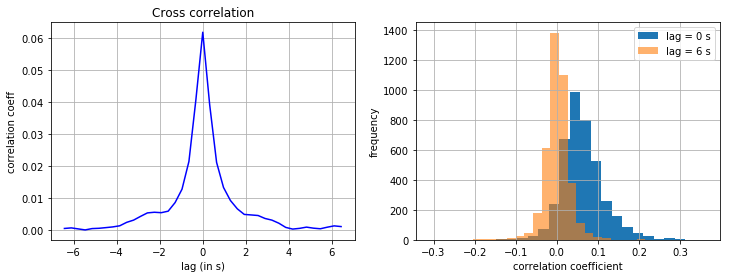

In [14]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(dt*F*np.arange(-Ntau,Ntau+1),np.mean(Corr,axis=0),'b')
ax[0].set(xlabel='lag (in s)', ylabel = 'correlation coeff', title = 'Cross correlation')
ax[0].grid('on')

ax[1].hist(Corr[:,20],25)
ax[1].hist(Corr[:,-1],25,alpha=0.6)
ax[1].set(xlabel='correlation coefficient',ylabel='frequency')
ax[1].legend(['lag = 0 s', 'lag = 6 s'])
ax[1].grid('on')
fig.savefig("Figures/NeuralCorrelations.png",dpi=300)
fig.savefig("Figures/NeuralCorrelations.pdf")
plt.show()

In [15]:
# Arrange the traces according to the condition 
traces_s = np.zeros([Nc,NNeu,T])
for ii in range(Nc):
    idx = pick_indices(frame_times,fliptimes[ii,0],fliptimes[ii,-1])[0:T]
    traces_s[ii,:,:] = traces[:,idx]

In [16]:
# get the stimulus variables - OMap and CMap
Data = loadmat('OMap_VarmaTestPlatinum.mat')
OMapFull = Data['OMapFull']
Data = loadmat('CMap_VarmaTestPlatinum.mat')
CMapFull = Data['CMapFull']

# OMap is defined clockwise during stim generation (ended up that way!)
# Make it anti-clockwise. Also, the angle lines up with the stripes here.
OMapFull = 255 - OMapFull # because OMap takes values 0 to 255, corresponding to 0 to pi

# quantize OMap and CMap
Nbins_o = 8
Nbins_c = 2

OMapFull_q = np.uint8(np.floor(OMapFull*(Nbins_o/256.0)))
CMapFull_q = np.uint8(np.floor(CMapFull*(Nbins_c/256.0)))

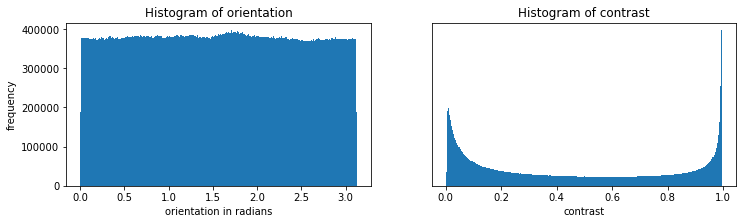

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(OMapFull.flatten()*np.pi/256,bins=256)
ax[0].set_title('Histogram of orientation')
ax[0].set_xlabel('orientation in radians')
ax[0].set_ylabel('frequency')


ax[1].hist(CMapFull.flatten()/256,bins=256)
ax[1].set_title('Histogram of contrast')
ax[1].set_xlabel('contrast')
ax[1].set_yticks([])

plt.savefig('Figures/Stimulus_histograms.png',dpi=400)
plt.savefig('Figures/Stimulus_histograms.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(m1, interpolation='None')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(m2, interpolation='None')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');


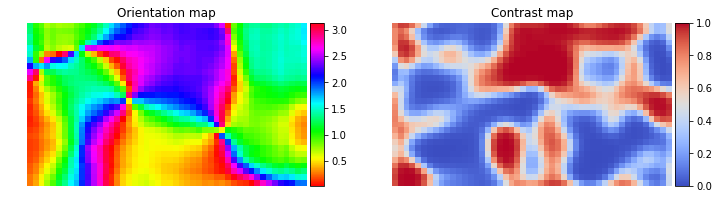

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
im = ax[0].imshow(OMapFull[:,:,0,20]*np.pi/255,cmap='hsv')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].axis('off')
ax[0].set_title('Orientation map')

im = ax[1].imshow(CMapFull[:,:,0,20]/255,cmap='coolwarm')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].axis('off')
ax[1].set_title('Contrast map')

plt.savefig('Figures/Example_OMap_CMap.png',dpi=400)
plt.savefig('Figures/Example_OMap_CMap.pdf')
plt.show()

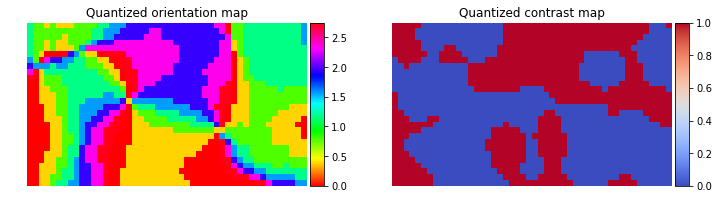

In [34]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
im = ax[0].imshow(OMapFull_q[:,:,0,20]*np.pi/Nbins_o,cmap='hsv')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].axis('off')
ax[0].set_title('Quantized orientation map')

im = ax[1].imshow(CMapFull_q[:,:,0,20],cmap='coolwarm')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].axis('off')
ax[1].set_title('Quantized contrast map')

plt.savefig('Figures/Example_OMap_CMap_Quantized.png',dpi=400)
plt.savefig('Figures/Example_OMap_CMap_Quantized.pdf')
plt.show()

In [35]:
# get the STAs, estimated receptive field centers and the snr which quantifies the quality of the RF

tkeys, response_maps, rx, ry, snr = (tune.STA.Map() * tune.STAExtent() * tune.STAQual() 
                                     & key).fetch(dj.key, 'map','x','y', 'snr',order_by='unit_id')

print('No. of neurons in scan =',NNeu)
print('No. of neurons with estimated RF centers =',len(tkeys))

sortidx = np.argsort(snr)

# pick the best neurons
NNeu_sel = min(len(tkeys),1000)
sortidx = sortidx[-NNeu_sel:]
print('No. of neurons selected for further analysis =',NNeu_sel)

# record the unit_id, rx and ry for neurons with best RFs
# sort the neurons according to their snr
Unit_idVec = np.zeros([NNeu_sel],dtype='uint8')
RxVec = np.zeros([NNeu_sel])
RyVec = np.zeros([NNeu_sel])

for k in range(NNeu_sel):
    Unit_idVec[k] = tkeys[sortidx[k]]['unit_id']
    RxVec[k] = rx[sortidx[k]]
    RyVec[k] = ry[sortidx[k]]
    
# downsample by 4 to map the RFcenters to OMap and CMap
RxVec = np.round(RxVec/4.0)
RyVec = np.round(RyVec/4.0)

Py,Px = OMapFull.shape[0:2] #No. of pixels in OMap

No. of neurons in scan = 3926
No. of neurons with estimated RF centers = 675
No. of neurons selected for further analysis = 675


9.34469


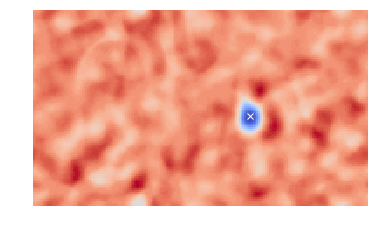

In [36]:
k = -1
print(snr[sortidx[k]])
plt.imshow(response_maps[sortidx[k]][:,:,1],cmap='coolwarm')
plt.axis('off')
plt.plot(4*RxVec[k],4*RyVec[k],'wx')
plt.savefig('Figures/ExampleRF.png',dpi=300)

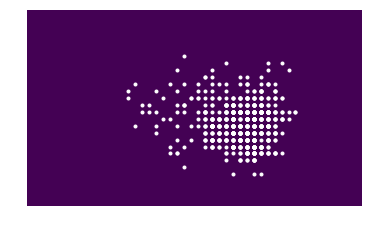

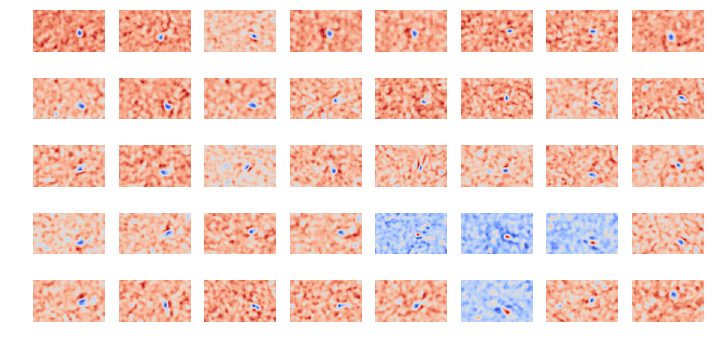

In [37]:
# Plot the RF centers
Ny,Nx = OMapFull.shape[0:2]
x,y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))

plt.figure()
plt.imshow(np.zeros([Ny,Nx]))
# plt.plot(x.flatten(),y.flatten(),'k.')
plt.plot(RxVec,RyVec,'w.')
plt.axis('off')
plt.savefig('Figures/RFCenters.png',dpi=300)
plt.show()

# plot example RFs of a few neurons
plt.figure()
plt.subplots(5,8,figsize=(12,6))
for k in range(40):
    plt.subplot(5,8,k+1)
    plt.imshow(response_maps[sortidx[-k-1]][:,:,1],cmap = 'coolwarm')
    plt.axis('off')
plt.savefig('Figures/ExampleRFs.png',dpi=400)
plt.savefig('Figures/ExampleRFs.pdf')
plt.show()

    

In [38]:
# To compute the tuning curves and do further analysis, we need to obtain
# neural activity for each condition synchronized with the frame times

Nc_V = 40 # No. of Varma conditions
Nreps = 2 # each condition was repeated twice 
spikesReq = np.zeros([Nreps,Nc_V,NNeu_sel,T])

# Arrange the activity such that the conditions in natural order i.e., 0,1,2, ...         
for k in range(Nc_V):
    spikesReq[0,k,:,:] = traces_s[aidx1[k],Unit_idVec,:]
    spikesReq[1,k,:,:] = traces_s[aidx2[k] + 60,Unit_idVec,:]

# Next we will sync the stimulus with the frame times by nearest neigh. interpolation
OMapReq = np.zeros([Nreps,Nc_V,Ny,Nx,T],dtype='uint8')
CMapReq = np.zeros([Nreps,Nc_V,Ny,Nx,T],dtype='uint8')

for ii in range(Nc_V):
    
    fl_t0 = fliptimes[aidx1[ii],:]
    fl_t1 = fliptimes[aidx2[ii]+60,:] 
    #60 because the first 60 conditions include 40 Varma and 20 CM trippy
    
    id_str = np.nonzero(frame_times >= fl_t0[0])[0]
    id_end = np.nonzero(frame_times <= fl_t0[-1])[0]
    idx0 = np.intersect1d(id_str,id_end)
    idx0 = idx0[0:T]
    
    id_str = np.nonzero(frame_times >= fl_t1[0])[0]
    id_end = np.nonzero(frame_times <= fl_t1[-1])[0]
    idx1 = np.intersect1d(id_str,id_end)
    idx1 = idx1[0:T]

    # frame times for stimulus corresponding to these sessions
    fr_t0 = frame_times[idx0];
    fr_t1 = frame_times[idx1];

    fr_t0 = fr_t0 - fl_t0[0];
    fl_t0 = fl_t0 - fl_t0[0];
    
    fr_t1 = fr_t1 - fl_t1[0];
    fl_t1 = fl_t1 - fl_t1[0];
    

    # find nearest frame 
    for tt in range(T):
        # for rep 0
        idxa = np.nonzero(fl_t0 >= fr_t0[tt])[0]
        idxa = idxa[0]
        idxb = np.nonzero(fl_t0 < fr_t0[tt])[0]
        idxb = idxb[-1]
        da = fl_t0[idxa] - fr_t0[tt]
        db = fr_t0[tt] - fl_t0[idxb]
        if da <= db:
            idx = idxa
        else:
            idx = idxb
        OMapReq[0,ii,:,:,tt] = OMapFull_q[:,:,idx,ii]
        CMapReq[0,ii,:,:,tt] = CMapFull_q[:,:,idx,ii]
        
        # for rep 1
        idxa = np.nonzero(fl_t1 >= fr_t1[tt])[0]
        idxa = idxa[0]
        idxb = np.nonzero(fl_t1 < fr_t1[tt])[0]
        idxb = idxb[-1]
        da = fl_t1[idxa] - fr_t1[tt]
        db = fr_t1[tt] - fl_t1[idxb]
        if da <= db:
            idx = idxa
        else:
            idx = idxb
        OMapReq[1,ii,:,:,tt] = OMapFull_q[:,:,idx,ii]
        CMapReq[1,ii,:,:,tt] = CMapFull_q[:,:,idx,ii]

        


In [39]:
# we are now ready to compute the tuning curves
FS_All = np.zeros([NNeu_sel,Nbins_o,Nbins_c]) 

for nn in range(NNeu_sel):
    # Initialize Tuning curves
    TC_All = np.zeros([Nreps, Nc_V, Nbins_o, Nbins_c])

    # Pick the RF center
    px = np.int(RxVec[nn])
    py = np.int(RyVec[nn])

    # initialize tuning curve 
    fs = np.zeros([Nbins_o, Nbins_c]) 
    
    # Compute the tuning curves by binning 
    for rep in range(Nreps):
        for ii in range(Nc_V):
            for kk in range(Nbins_o):
                for ll in range(Nbins_c):
                    idx_o = np.nonzero(OMapReq[rep,ii,py,px,:] == kk)[0]
                    idx_c = np.nonzero(CMapReq[rep,ii,py,px,:] == ll)[0]
                    idx = np.intersect1d(idx_o,idx_c)
                    if np.shape(idx)[0] == 0:
                        fs[kk,ll] = 0
                    else:
                        fs[kk,ll] = np.mean(spikesReq[rep,ii,nn,idx])

            TC_All[rep,ii,:,:] = fs


    FS = np.mean(np.mean(TC_All,axis=0),axis=0)
    FS_All[nn,:,:] = FS
    


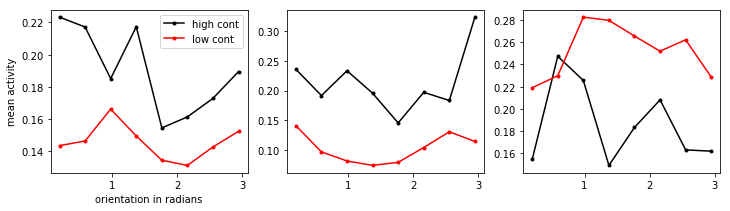

In [41]:
ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o
fig,ax = plt.subplots(1,3,figsize=(12,3))
for k in range(3):
    ax[k].plot(ori_set,FS_All[-k-1,:,1],'k.-')
    ax[k].plot(ori_set,FS_All[-k-1,:,0],'r.-')
    ax[0].set_xlabel('orientation in radians')
    ax[0].set_ylabel('mean activity')
    ax[0].legend(['high cont','low cont'])
    
plt.savefig('Figures/ExampleTuningCurves.png',dpi=300)
plt.savefig('Figures/ExampleTuningCurves.pdf')

In [42]:
# count the number of neurons for which tuning to lower contrast is higher
count = 0
LCIdx = [] #low contrast preferred tuning
HCIdx = []
for k in range(NNeu_sel):
    mlow = np.max(FS_All[k,:,0])
    mhigh = np.max(FS_All[k,:,1])
    if mlow > mhigh:
        count += 1
        LCIdx.append([k])
    else:
        HCIdx.append([k])

print(count)

321


In [43]:
LCIdx = np.asarray(LCIdx).squeeze()
HCIdx = np.asarray(HCIdx).squeeze()
req_rmaps = response_maps[sortidx]

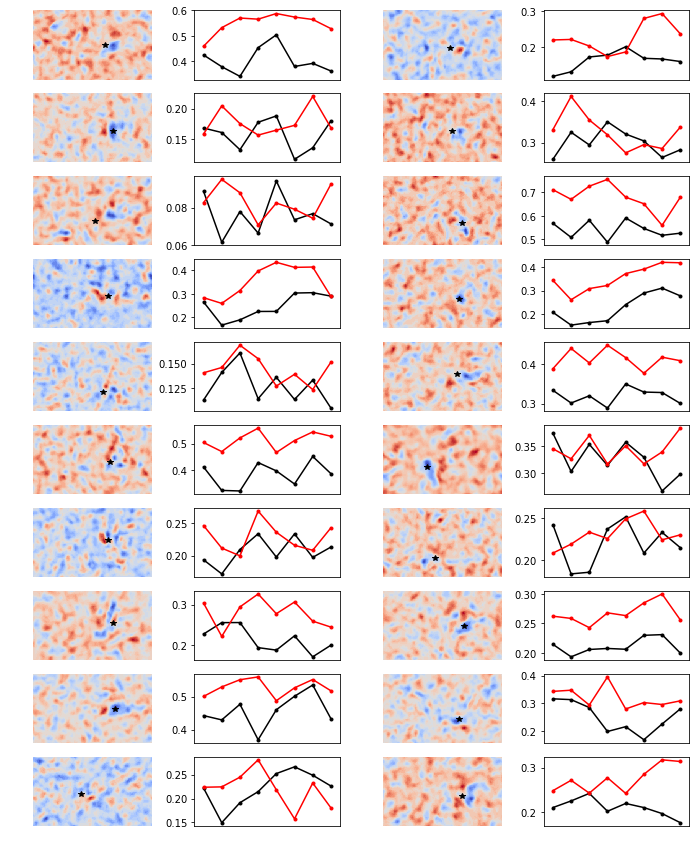

In [44]:
# inspect the tuning curves and the RFs for these neurons and where the RF centers line up
plt.figure()
K = 10

f2, axes2 = plt.subplots(K,4,figsize=(12,15))

for ax, k in zip(axes2, np.arange(K)):
    rmap = req_rmaps[LCIdx[k]]
    fsc = FS_All[LCIdx[k],:,:]
    rx = RxVec[LCIdx[k]]
    ry = RyVec[LCIdx[k]]
    
    ax[0].imshow(rmap[:,:,1],cmap='coolwarm')
    ax[0].plot(4*rx,4*ry,'k*')
    ax[0].axis('off')
    ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,1],'k.-')
    ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,0],'r.-')
    ax[1].axes.set_xlim((0,np.pi))
    ax[1].set_xticks([])
    
    rmap = req_rmaps[LCIdx[k+K]]
    fsc = FS_All[LCIdx[k+K],:,:]
    rx = RxVec[LCIdx[k+K]]
    ry = RyVec[LCIdx[k+K]]
    
    ax[2].imshow(rmap[:,:,1],cmap='coolwarm')
    ax[2].plot(4*rx,4*ry,'k*')
    ax[2].axis('off')
    ax[3].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,1],'k.-')
    ax[3].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,0],'r.-')
    ax[3].axes.set_xlim((0,np.pi))
    ax[3].set_xticks([])
    
plt.savefig('Figures/LowContrastPreferringCells.png',dpi=400)
plt.savefig('Figures/LowContrastPreferringCells.pdf')

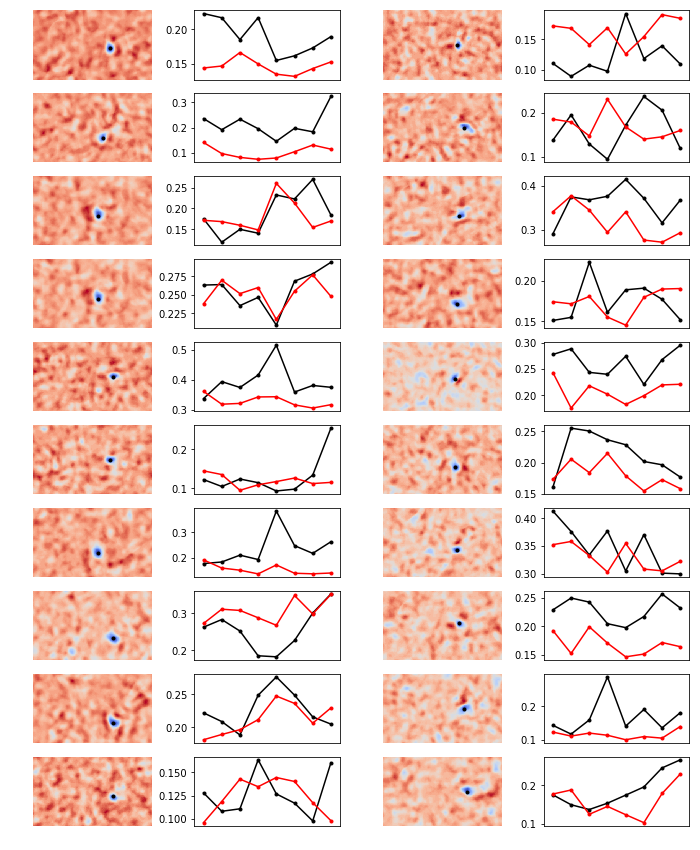

In [45]:
# inspect the tuning curves and the RFs for the high contrast preferring neurons 
# and where the RF centers line up

plt.figure()
K = 10
f2, axes2 = plt.subplots(K,4,figsize=(12,15))

for ax, k in zip(axes2, np.arange(K)):
    rmap = req_rmaps[HCIdx[-k-1]]
    fsc = FS_All[HCIdx[-k-1],:,:]
    rx = RxVec[HCIdx[-k-1]]
    ry = RyVec[HCIdx[-k-1]]
    
    ax[0].imshow(rmap[:,:,1],cmap='coolwarm')
    ax[0].plot(4*rx,4*ry,'k.')
    ax[0].axis('off')
    ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,1],'k.-')
    ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,0],'r.-')
    ax[1].axes.set_xlim((0,np.pi))
    ax[1].set_xticks([])
    
    rmap = req_rmaps[HCIdx[-k-1-K]]
    fsc = FS_All[HCIdx[-k-1-K],:,:]
    rx = RxVec[HCIdx[-k-1-K]]
    ry = RyVec[HCIdx[-k-1-K]]
    
    ax[2].imshow(rmap[:,:,1],cmap='coolwarm')
    ax[2].plot(4*rx,4*ry,'k.')
    ax[2].axis('off')
    ax[3].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,1],'k.-')
    ax[3].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc[:,0],'r.-')
    ax[3].axes.set_xlim((0,np.pi))
    ax[3].set_xticks([])
    
plt.savefig('Figures/HighContrastPreferringCells.png',dpi=400)
plt.savefig('Figures/HighContrastPreferringCells.pdf')

In [46]:
# Now to do the von Mises fits

AmpVec = np.zeros([NNeu_sel,2]) #vector of amplitudes
KVec = np.zeros([NNeu_sel,2]) # vector of scale factors for the neurons
ThetaVec = np.zeros([NNeu_sel,2]) # vector of preferred orientations

ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o

init_vals = [1, 1, np.pi/2]     # for [amp, scale, theta0]
lb = [0,0,0]
ub = [10,10,np.pi]

for k in range(NNeu_sel):
    for c in range(Nbins_c):
        FS = FS_All[k,:,c]
        best_vals, covar = curve_fit(vonMisesFn, ori_set, FS, p0=init_vals,bounds=(lb,ub))
        AmpVec[k,c] = best_vals[0]
        KVec[k,c] = best_vals[1]
        ThetaVec[k,c] = best_vals[2]


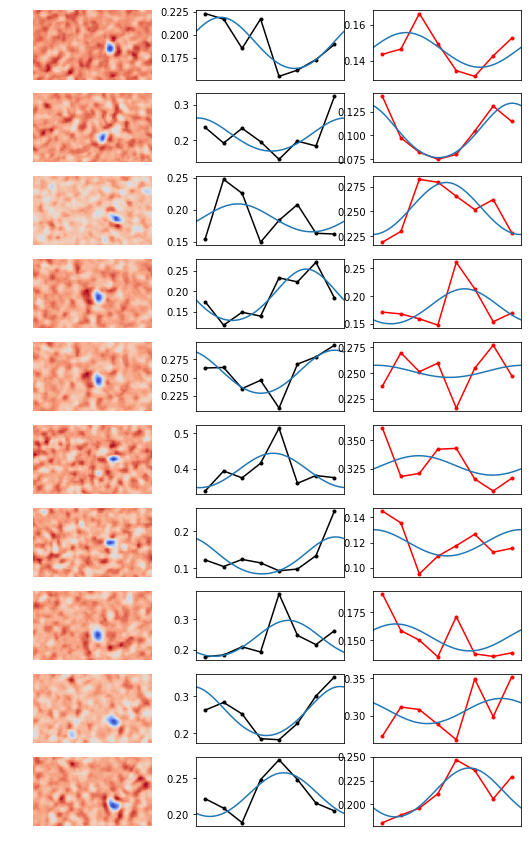

In [48]:
plt.figure()
K = 10
f2, axes2 = plt.subplots(10,3,figsize=(9,15))
for ax, k in zip(axes2,np.arange(K)):
    theta = np.linspace(0,np.pi,100)
    kk = -k-1
    
    rmap = response_maps[sortidx[kk]]
    ax[0].imshow(rmap[:,:,1],cmap='coolwarm')
    ax[0].axis('off')
    
    A = AmpVec[kk,1]
    K = KVec[kk,1]
    Th = ThetaVec[kk,1]
    fsc = FS_All[kk,:,1]
    vfit = vonMisesFn(theta,A,K,Th)
    
    ax[1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'k.-')
    ax[1].plot(np.linspace(0,np.pi,100),vfit)
    ax[1].axes.set_xlim((0,np.pi))
    ax[1].set_xticks([])
    
    A = AmpVec[kk,0]
    K = KVec[kk,0]
    Th = ThetaVec[kk,0]
    fsc = FS_All[kk,:,0]
    vfit = vonMisesFn(theta,A,K,Th)
    
    ax[2].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'r.-')
    ax[2].plot(np.linspace(0,np.pi,100),vfit)
    ax[2].axes.set_xlim((0,np.pi))
    ax[2].set_xticks([])

plt.savefig('Figures/VonMisesFitstoTuningCurves.png',dpi=300)
plt.savefig('Figures/VonMisesFitstoTuningCurves.pdf')

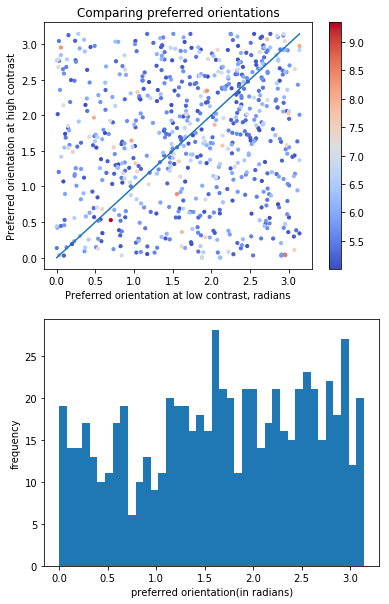

In [54]:
#colors = np.tanh(snr[sortidx]  - snr.mean())
colors = snr[sortidx]
plt.subplots(2,1,figsize=(6,10))
plt.subplot(2,1,1)
#plt.plot(ThetaVec[:,0],ThetaVec[:,1],'k.')
plt.scatter(ThetaVec[:,0],ThetaVec[:,1],s = 10*np.ones([NNeu_sel]),c=colors,cmap='coolwarm')
plt.colorbar()
plt.plot([0,np.pi],[0,np.pi])
plt.xlabel('Preferred orientation at low contrast, radians')
plt.ylabel('Preferred orientation at high contrast')
plt.title('Comparing preferred orientations')
plt.subplot(2,1,2)
plt.hist(ThetaVec[:,1],40)
plt.xlabel('preferred orientation(in radians)')
plt.ylabel('frequency')
plt.savefig('Figures/DistributionOfPreferredOrientations.png',dpi=300)
plt.show()

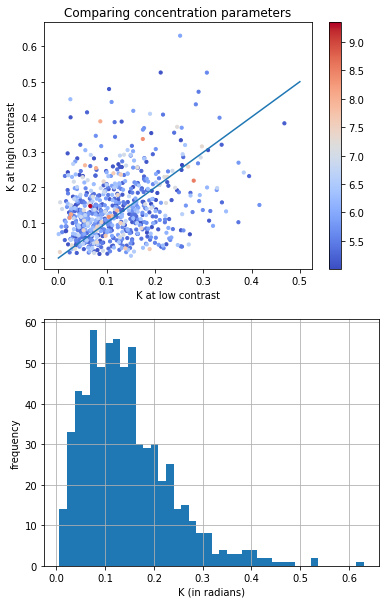

In [56]:
plt.subplots(2,1,figsize=(6,10))
plt.subplot(2,1,1)
plt.scatter(KVec[:,0],KVec[:,1],s = 10*np.ones([NNeu_sel]),c=colors,cmap='coolwarm')
plt.plot([0,.5],[0,.5])
plt.xlabel('K at low contrast')
plt.ylabel('K at high contrast')
plt.colorbar()
plt.title('Comparing concentration parameters')
plt.subplot(2,1,2)
plt.hist(KVec[:,1],40)
plt.xlabel('K (in radians)')
plt.ylabel('frequency')
plt.grid('on')
plt.savefig('Figures/DistributionOfConcentrations.png',dpi=300)
plt.show()

In [59]:
# # Construct the PPCs
# # this is for 17797_6_8
# id_PPC = []

# id_x = pick_indices(RxVec,20,22)
# id_y = pick_indices(RyVec,12,14)
# id_PPC.append(np.intersect1d(id_x,id_y))

# id_x = pick_indices(RxVec,20,22)
# id_y = pick_indices(RyVec,9,11)
# id_PPC.append(np.intersect1d(id_x,id_y))

# id_x = pick_indices(RxVec,20,22)
# id_y = pick_indices(RyVec,15,17)
# id_PPC.append(np.intersect1d(id_x,id_y))

# id_x = pick_indices(RxVec,17,19)
# id_y = pick_indices(RyVec,12,14)
# id_PPC.append(np.intersect1d(id_x,id_y))

# id_x = pick_indices(RxVec,23,25)
# id_y = pick_indices(RyVec,12,14)
# id_PPC.append(np.intersect1d(id_x,id_y))

# # plot the RF centers and show grouping of the PPCs
# plt.figure()
# plt.imshow(np.zeros([Ny,Nx]))
# plt.plot(x.flatten(),y.flatten(),'k.')
# plt.plot(RxVec,RyVec,'w.')
# plt.plot(RxVec[id_PPC[0]],RyVec[id_PPC[0]],'r.')
# plt.plot(RxVec[id_PPC[1]],RyVec[id_PPC[1]],'g.')
# plt.plot(RxVec[id_PPC[2]],RyVec[id_PPC[2]],'b.')
# plt.plot(RxVec[id_PPC[3]],RyVec[id_PPC[3]],'c.')
# plt.plot(RxVec[id_PPC[4]],RyVec[id_PPC[4]],'y.')
# plt.axis('off')
# plt.savefig('RFCenters.pdf')
# plt.show()

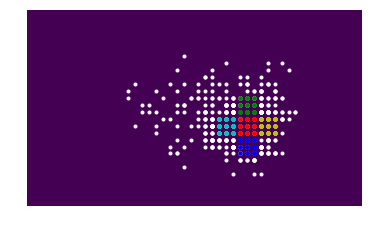

In [51]:
#Construct the PPCs
# this is for 18142
id_PPC = []

id_x = pick_indices(RxVec,30,32)
id_y = pick_indices(RyVec,15,17)
id_PPC.append(np.intersect1d(id_x,id_y))

id_x = pick_indices(RxVec,30,32)
id_y = pick_indices(RyVec,12,14)
id_PPC.append(np.intersect1d(id_x,id_y))

id_x = pick_indices(RxVec,30,32)
id_y = pick_indices(RyVec,18,20)
id_PPC.append(np.intersect1d(id_x,id_y))

id_x = pick_indices(RxVec,27,29)
id_y = pick_indices(RyVec,15,17)
id_PPC.append(np.intersect1d(id_x,id_y))

id_x = pick_indices(RxVec,33,35)
id_y = pick_indices(RyVec,15,17)
id_PPC.append(np.intersect1d(id_x,id_y))

# plot the RF centers and show grouping of the PPCs
plt.figure()
plt.imshow(np.zeros([Ny,Nx]))
#plt.plot(x.flatten(),y.flatten(),'k.')
plt.plot(RxVec,RyVec,'w.')
plt.plot(RxVec[id_PPC[0]],RyVec[id_PPC[0]],'r.')
plt.plot(RxVec[id_PPC[1]],RyVec[id_PPC[1]],'g.')
plt.plot(RxVec[id_PPC[2]],RyVec[id_PPC[2]],'b.')
plt.plot(RxVec[id_PPC[3]],RyVec[id_PPC[3]],'c.')
plt.plot(RxVec[id_PPC[4]],RyVec[id_PPC[4]],'y.')
plt.axis('off')
plt.savefig('Figures/PPCgroups.png',dpi=300)
plt.show()

In [52]:
for k in range(len(id_PPC)):
    print(len(id_PPC[k]))

89
65
76
66
55


In [76]:
spikesReq[:,:,0,:].shape

(2, 40, 372)

(5, 2, 40, 372)


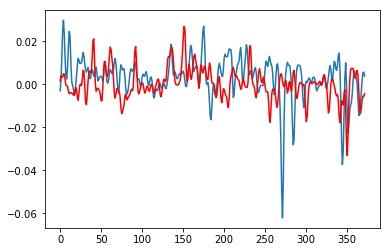

In [77]:
# Compute the cos and sin statistics
R_cos = np.zeros([len(id_PPC),Nreps,Nc_V,T])
R_sin = np.zeros([len(id_PPC),Nreps,Nc_V,T])

for ii in range(len(id_PPC)):
    idx = id_PPC[ii]
    ThetaPPC = expandN_dims(ThetaVec[idx,1],3)
    ThetaPPC = ThetaPPC.transpose([1,2,0,3])
    KPPC = expandN_dims(KVec[idx,1],3)
    KPPC = KPPC.transpose([1,2,0,3])
    
    R_cos[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*KPPC*np.cos(2*ThetaPPC),axis=2)/len(idx)
    R_sin[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*KPPC*np.sin(2*ThetaPPC),axis=2)/len(idx)
    
    #R_cos[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*WVecC*KPPC*np.cos(2*ThetaPPC),axis=2)
    #R_sin[ii,:,:,:] = np.sum(spikesReq[:,:,idx,:]*WVecC*KPPC*np.sin(2*ThetaPPC),axis=2)
    
    
# # normalize the statistics to compute the cross-corr
# R_cos_ZN = R_cos - np.expand_dims(np.mean(R_cos,axis=3),axis=3)
# R_cos_ZN = R_cos/np.expand_dims(np.std(R_cos,axis=3),axis=3)
# R_sin_ZN = R_cos - np.expand_dims(np.mean(R_sin,axis=3),axis=3)
# R_sin_ZN = R_cos/np.expand_dims(np.std(R_sin,axis=3),axis=3)

# plot example statistics from 2 repeats
plt.plot(R_sin[0,0,1,:])
plt.plot(R_sin[0,1,1,:],'r')
print(R_cos.shape)

[-0.1, 0.1, -0.1, 0.1]

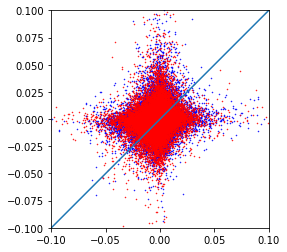

In [69]:
plt.plot(R_cos[:,0,0:20,:].flatten(),R_cos[:,1,0:20,:].flatten(),'b.',markersize=1)
plt.plot(R_cos[:,0,20:,:].flatten(),R_cos[:,1,20:,:].flatten(),'r.',markersize=1)
plt.axis('square')
plt.plot([-0.1,0.2],[-0.1,0.2])
plt.axis([-0.1,0.1,-0.1,0.1])

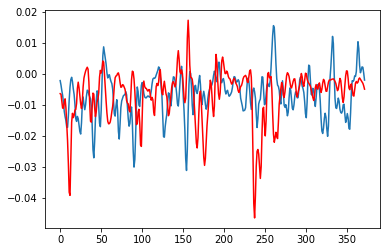

In [73]:
# plot example statistics from 2 repeats
plt.plot(R_sin[2,0,20,:])
plt.plot(R_sin[2,1,20,:],'r')


In [83]:
# computing the cross correlations for these statistics

Ntau = 20 
Corr_cos = np.zeros([len(id_PPC), Nc_V, 2*Ntau+1]) #Nc/2 because there are 2 repetitions of each cond
Corr_sin = np.zeros([len(id_PPC), Nc_V, 2*Ntau+1])
F = 2

for tau in range(-Ntau,Ntau+1):
    if tau < 0:
        Corr_cos[:,:,tau+Ntau] = np.mean(R_cos_ZN[:,0,:,-F*tau:]*R_cos_ZN[:,1,:,0:T+F*tau],axis=2)
        Corr_sin[:,:,tau+Ntau] = np.mean(R_sin_ZN[:,0,:,-F*tau:]*R_sin_ZN[:,1,:,0:T+F*tau],axis=2)
    elif tau >= 0:
        Corr_cos[:,:,tau+Ntau] = np.mean(R_cos_ZN[:,0,:,0:T-F*tau]*R_cos_ZN[:,1,:,F*tau:],axis=2)
        Corr_sin[:,:,tau+Ntau] = np.mean(R_sin_ZN[:,0,:,0:T-F*tau]*R_sin_ZN[:,1,:,F*tau:],axis=2)
        

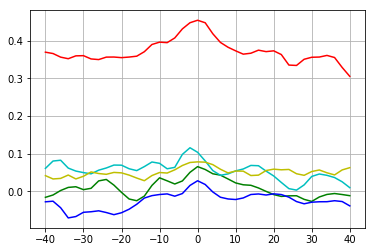

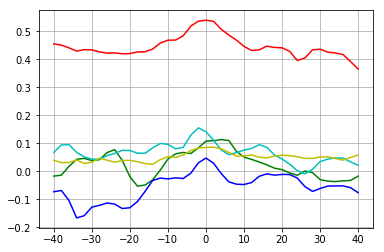

In [84]:
# plot the cross correlation fot these statistics
CC = np.mean(Corr_cos,axis=1)
CS = np.mean(Corr_sin,axis=1)

plt.plot(F*np.arange(-Ntau,Ntau+1),CC[0,:],'r')
plt.plot(F*np.arange(-Ntau,Ntau+1),CC[1,:],'g')
plt.plot(F*np.arange(-Ntau,Ntau+1),CC[2,:],'b')
plt.plot(F*np.arange(-Ntau,Ntau+1),CC[3,:],'c')
plt.plot(F*np.arange(-Ntau,Ntau+1),CC[4,:],'y')
plt.grid('on')
plt.savefig('Corr_cos.pdf')
plt.show()

plt.plot(F*np.arange(-Ntau,Ntau+1),CS[0,:],'r')
plt.plot(F*np.arange(-Ntau,Ntau+1),CS[1,:],'g')
plt.plot(F*np.arange(-Ntau,Ntau+1),CS[2,:],'b')
plt.plot(F*np.arange(-Ntau,Ntau+1),CS[3,:],'c')
plt.plot(F*np.arange(-Ntau,Ntau+1),CS[4,:],'y')
plt.grid('on')
plt.savefig('Corr_sin.pdf')
plt.show()

In [22]:
for i in range(len(id_PPC)):
    print(len(id_PPC[i]))

164
175
55
94
87


In [149]:
# # how to extract movie related stuff
# mkeys, cmmovie, cmlabel = (stimulus.CMTrippy()).fetch(dj.key, 'movie','rng_seed')
# # mkeys, cmmovie, cmlabel = (stimulus.Trial()*stimulus.CMTrippy() & key).fetch(dj.key, 'movie','rng_seed')

# plt.matshow(cmmovie[0][:,:,-2],cmap='coolwarm')